# Introduction to Neural Networks and Deep Learning

# Chapter 1: Hands on Neural Networks and CNNs

## Prof. Aldo Humberto Romero, Physics Department, West Virginia University

## A lot of these notebooks are based on the course prepared at West Virginia University by the research computing group led by Aldo Humberto Romero by mostly done by Guillermo Avendaño-Franco.


In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2023-02-14T18:04:03.992503-05:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.9.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



import time
start = time.time()
chapter_number = 1
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
chapter_number = 2
import time
start = time.time()

In [4]:
%watermark -iv

numpy     : 1.23.5
tensorflow: 2.11.0
matplotlib: 3.6.3



In [5]:
epoch_reduction_factor = 1.0
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("Using TensorFlow CPU only, lowering the number of epochs")
    epoch_reduction_factor = 0.5

Using TensorFlow CPU only, lowering the number of epochs


In [ ]:
# IN what follows, we will use data that is stored in the subdirectory data in your current directory
# if you are using google colab to study this material, you will have to
#  Upload the data directory into your google drive
#  Link your google drive into your google collab, this is done by uncommenting the following lines

# from google.colab import drive

###  This line will take you to your google account, where you give permission to google collab to have access to it
# drive.mount('/content/gdrive')

## if you want to see the content, just type
# !ls "/content/gdrive/My Drive/"

## END OF LINES TO UNCOMMENT

# now, when you are trying to access the data in collab, you have change for example the line

#  ./data/keras/datasets/mnist.npz

# to

# /content/gdrive/My Drive/data/keras/datasets/mnist.npz


## IMPORTANT

To use this notebook and the next ones you need to download the data necessary for that. You can do it by following the link

https://drive.google.com/drive/folders/1x-LNDzPQ-AivI9xCM8h4EWg8ppzgfXD6?usp=share_link



# The MNIST Dataset of handwritten digits

The MNIST dataset of handwritten digits is a classical problem in Machine Learning and an iconic problem in Convolutional Neural Networks.

The MNIST database was constructed from joining two datasets/databases. The NIST's Special Database 3 and Special Database 1. Both datasets contain binary images of handwritten digits. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found in the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of the training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. For the test set, 5,000 patterns were taken from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint.

The dataset has a training set of 60,000 examples and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

Yann LeCun has a page dedicated to the [MNIST DATASET](http://yann.lecun.com/exdb/mnist) with a list of publications where the dataset has been used.

The advantage of using these kinds of datasets is that all the preprocessing and normalization has been done, and some Machine Learning and Deep Learning Frameworks include it with the code or provide easy routines to download it. Let's explore this dataset using TensorFlow and the Keras library.

In [6]:
def load_data():
    path = './data/keras/datasets/mnist.npz'

    with np.load(path, allow_pickle=True) as f:  # pylint: disable=unexpected-keyword-arg
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [7]:
# **NOTE:** This only works with an internet connection
#
# mnist = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = load_data()

We have now 4 numpy arrays `train_images`, `train_labels`, `test_images`, and `test_labels`. 
The shapes of those arrays follows:

In [8]:
train_images.shape
#print(train_images[0,:,:])

(60000, 28, 28)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
train_labels.shape
print(train_labels[0])

5


In [11]:
test_labels.shape

(10000,)

It will be pointless to look at all those images but we can have a peek into how they look for a small sample of them.

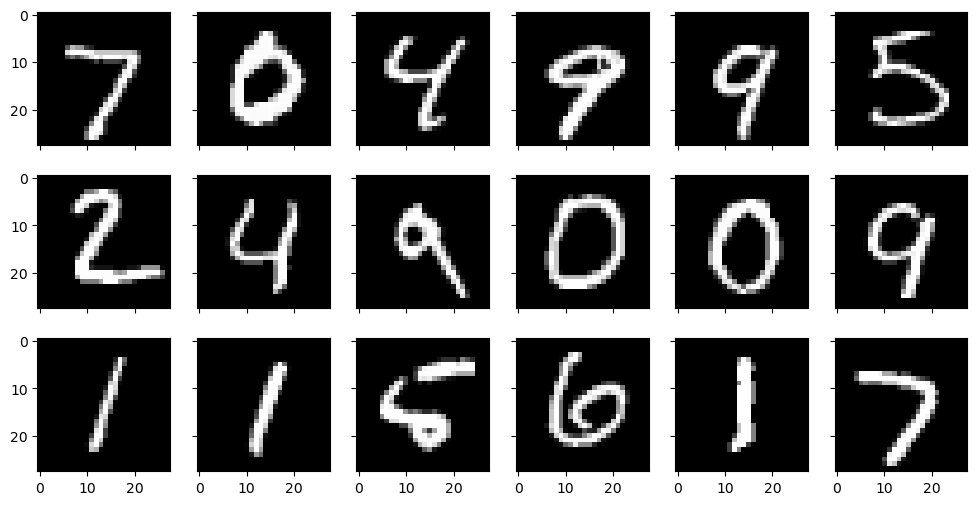

In [12]:
N=3
M=6
fig, axs = plt.subplots(N,M,sharex=True, sharey=True, figsize=(12,6))
for i in range(N):
    for j in range(M):
        axs[i,j].imshow(test_images[N*j+i], cmap='gray', interpolation='none')

Each image is a $28 \times 28$ grayscale bitmap. Let's see one of them

In [13]:
test_images[0].shape[0]

28

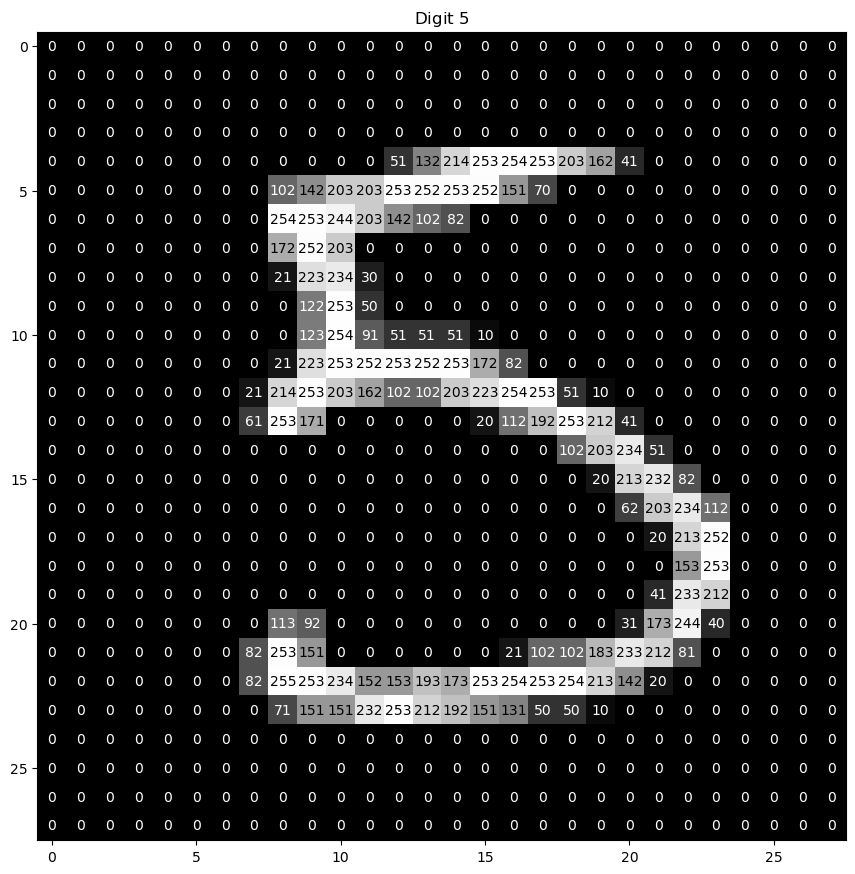

In [14]:
image_num=15
plt.gcf().set_size_inches(18.5, 10.5)
plt.imshow(test_images[image_num], cmap='gray', interpolation='none')
plt.title(r'Digit ${}$'.format(test_labels[image_num]));
for i in range(test_images[image_num].shape[0]):
    for j in range(test_images[image_num].shape[1]):
        if test_images[image_num][i][j]<128:
            fontcolor='white'
        else:
            fontcolor='black'
        plt.text(j,i,str(test_images[image_num][i][j]),color=fontcolor, 
                 horizontalalignment='center',
                 verticalalignment='center')

## Transforming the images into a 1-D vector

Our first task is to work out the simplest possible Neural Network model just to show how the TensorFlow framework functions. Then we will gradually implement our way to a quite sophisticated and accurate convolutional neural network for this same problem. 

First, we need to convert the images into 1D vectors. In NumPy that is called a `reshape`. The data is the same, but it now looks like $60000 \times 784$ array instead of the $60000 \times 28 \times 28$.

Another, change is to convert the original values of the array from integers into floating point numbers and divide those by 255 to get a value *normalized* between $0$ and $1$. This is a convenience as many Deep Learning models work better with values in small ranges.

In [15]:
train_images = train_images.reshape(60000, 784) 
print(train_images.shape)
test_images = test_images.reshape(10000, 784)
test_images = test_images.astype('float32') 
train_images = train_images.astype('float32')
test_images /= 255 
train_images /= 255

(60000, 784)


## Defining the model, our first Dense Neural Network

It is time to design the model. Models in Keras (tensorflow) are defined as a sequence of layers. 

We create a Sequential model and add layers one at a time until we are happy with our network architecture. The first thing to get right is to ensure the input layer has the correct number of input features. This can be specified when creating the first layer with the input_shape argument and setting it to (784,) for presenting the 784 input variables as a vector.

We want the network to take $784$ values in the input and feed with them the first layer of $64$ neurons which in turn feed another layer of $64$ to finalize with another layer of $10$. For the activation functions, we will use **ReLU** the function that we saw before. 

Like this

<div>
    <br>
  <table>
  <tr>
    <th><img src="./fig/NN_Basic.png" width="600" /></th>
  </tr>
  </table>
</div>      






In [16]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

# a different method would be 

#  model = Sequential()
#  model.add(Dense(64, activation='relu', input_shape=(884,)))
# ....
#  model.summary()


In [ ]:
model.summary()

### Softmax activation

The final activation function will be a **softmax**. Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Therefore, the function **softmax** will return 10 values where the sum of them is 1. They will indicate the probability of each input to be associated to one of the 10 digits (multiclass classification problem). 

The standard (unit) softmax function $\sigma : \mathbb{R}^K\to (0,1)^K$ is defined $K>1$ by the formula

$$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \ \ \ \text{ for } i = 1, \dotsc , K \text{ and } \mathbf z=(z_1,\dotsc,z_K) \in \mathbb{R}^K.$$

In our case, $K=10$ and **softmax** is exactly the function we need to classify the digits.

In simple terms, **softmax** applies an exponential to each element $z_i$ of the vector $\mathbf z$ and normalizes these values by dividing by the sum of all these exponentials; this normalization ensures that the sum of the components of the output vector $\sigma(\mathbf z)$ is 1. This is the reason why we can take the output as the probability of the input image being any of the 10 digits.

There is another advantage of using softmax. The values returned at the end of the last layer could be of all sorts, negative values, large and small. softmax reduces all that to all positive, less than 1 set of values. 
See the table below for some examples:

In [ ]:
z = np.array([ 8.1, -17.5, 10.6, 1.2, -1.5, 13.9,  -3.4, -5.4, 0.05, -2.0])

In [ ]:
exp_z=np.exp(z)
exp_z

In [ ]:
sm_z=np.exp(z)/np.sum(np.exp(z))
sm_z

In [ ]:
np.sum(np.exp(z)/np.sum(np.exp(z)))

In [ ]:
for i in range(10):
    print('|{:d}|{:.3f}|{:.3e}|{:.3e}|'.format(i,z[i],exp_z[i],sm_z[i]))

| Digit | Ouptut |Exponential | Normalized |
| --- | --- | --- | --- |
|0|8.100|3.294e+03|2.911e-03|
|1|-17.500|2.511e-08|2.219e-14|
|2|10.600|4.013e+04|3.547e-02|
|3|1.200|3.320e+00|2.934e-06|
|4|-1.500|2.231e-01|1.972e-07|
|5|13.900|1.088e+06|9.616e-01|
|6|-3.400|3.337e-02|2.949e-08|
|7|-5.400|4.517e-03|3.991e-09|
|8|0.050|1.051e+00|9.290e-07|
|9|-2.000|1.353e-01|1.196e-07|

In [17]:
names = [ str(x) for x in np.arange(10)]
values = sm_z

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.bar(names, values, log=False);
plt.subplot(212)
plt.bar(names, values, log=True);

NameError: name 'sm_z' is not defined

## Compiling the model, defining the backpropagation optimizer, loss function, and metrics

TensorFlow will use the arguments of the `compile` method to organize the procedure that will use to adjust the weights and biases. The values that control the output of our neural network. The optimizer `adam` is a usual choice for many Deep Learning problems. 

While training the deep learning optimizers model, we need to modify each epoch’s weights and minimize the loss function. An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. The problem of choosing the right weights for the model is a daunting task, as a deep learning model generally consists of millions of parameters. It raises the need to choose a suitable optimization algorithm for your application. Hence understanding these algorithms is necessary before having a deep dive into the field.


`sparse_categorical_crossentropy` is often used in classification problems like this. Using `accuracy` is a good metric knowing that we have a perfect balance between all the digits present in the dataset.

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Optimizers

Optimizers are the methods used to "change" the values of the weights and biases in order to reduce the losses. Let me name few:

#### Gradient Descent

Gradient Descent is the most basic but most used optimization algorithm. As we discussed before, backpropagation  uses a gradient descent algorithm. With the ingredient that gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function. It calculates that which way the weights should be altered so that the function can reach a minima. As discussed before, through backpropagation, the loss is transferred from one layer to another and the model’s parameters also known as weights are modified depending on the losses so that the loss can be minimized.

The possible problems are:

+ It can get trap in a local minima
+ As weights are recalculated for each element of the datasat, if the dataset is very large, this can take a lot of computational effort.
+ It could requiere a lot of memory to calculate over the whole dataset.


#### Stochastic Gradient Descent

A chosen number of elements in the dataset are selected and the model parameters are updated by using only this "random set" using the Gradient descent.

Problems:

+ Depending on the dataset, it can have high dispersion over the model parameters
+ As it is random, it can over shoot the solution when you try to go to the global minima
+ A solution is to reduce slowly the learning rate but you need to know how.

#### Momentum

It tries to improve over SGD by accelerating the convergence towards the relevant direction and reduces the fluctation in the irrelevant directions.  A new parameter is introduced, $\gamma$ which usually takes values between 0.7-0.9.

The way it works is by computing $\mathbf{V}(t)=\gamma \mathbf{V}(t−1)+ \eta \nabla \mathcal{L} (\mathbf{W})$ and with this new quantity, the weights are updated by $W=W-\mathbf{V}$.

#### Adagrad

In this optimizer, the learning rate also changes for each parameter and at each iteration. It works on the derivative of an error function.

#### AdaDelta

It is an extension of AdaGrad which tends to remove the decaying learning Rate problem of it. Instead of accumulating all previously squared gradients, Adadelta limits the window of accumulated past gradients to some fixed size $\omega$. 

#### Adam (Adaptive Moment Estimation) 

It works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search.

### Metrics for evaluation of the NN

Taken from https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

#### Classification Accuracy

$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions made}}$

Classification Accuracy is great, but gives us the false sense of achieving high accuracy.

#### Logarithmic Loss

Logarithmic Loss or Log Loss, works by penalising the false classifications. It works well for multi-class classification.When working with Log Loss, the classifier must assign probability to each class for all the samples. Suppose, there are N samples belonging to M classes, then the Log Loss is calculated as below

$\text{LogarithmicLoss} = \frac{-1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} \log p_{ij}$

$y_ij$, indicates whether sample i belongs to class j or not

$p_ij$, indicates the probability of sample i belonging to class j

Log Loss nearer to 0 indicates higher accuracy, whereas if the Log Loss is away from 0 then it indicates lower accuracy. In general, minimising Log Loss gives greater accuracy for the classifier.

#### Confusion Matrix

Confusion Matrix as the name suggests gives us a matrix as output and describes the complete performance of the model.

There are 4 important terms :

True Positives : The cases in which we predicted YES and the actual output was also YES.

True Negatives : The cases in which we predicted NO and the actual output was NO.

False Positives : The cases in which we predicted YES and the actual output was NO.

False Negatives : The cases in which we predicted NO and the actual output was YES.

Accuracy for the matrix can be calculated by taking average of the values lying across the “main diagonal”

$\frac{TruePositive+TrueNegative}{TotalSample}$

#### F1 Score

F1 Score is used to measure a test’s accuracy. F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is $[0, 1]$. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).
High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. Mathematically, it can be expressed as :

$F1=2 \cdot \frac{1}{\frac{1}{precision}+\frac{1}{recall}}$


F1 Score tries to find the balance between precision and recall.


Precision : It is the number of correct positive results divided by the number of positive results predicted by the classifier.


Recall : It is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).




### Cross Entropy Loss function

The loss function is the function that we try to minimize and should account for measuring a distance between the desired value and the value returned from the network under current weights and biases.

Given the very particular and sensible way we have constructed these outputs.

We could be using the Root Mean Square (RMS) as a loss function. The RMS defined as

$$\text{loss}_\text{RMS} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(y_i - y_i^{obj} \right)^2 }$$.

Where $y_i$ are the values obtained from the neural network and $y_i^{obj}$ and the values objective. 
This function is not a good idea for our case. See on the figure above that except for 1 value all the others are very small, it will be hard for an algorithm to know how in which direction to change the parameters when all produce such small values. We need somehow a way to undo the flattening of the **softmax**.

The Cross-Entropy Loss function is a good way to define the error across all possibilities. As we have seen, softmax converts logits into probabilities. The purpose of the Cross-Entropy is to take the output probabilities (P) and measure the distance from the truth values. Better than RMS. 
The Cross entropy function is defined as (for $n$ classes):

$$\text{loss}_\text{CE} =  - \sum_{i=1}^n y_i^{obj} \log y_i$$

Let's assume that in our case above, we are indeed in the presence of a digit $5$.
The value of $y^{obj}$ will be:

In [ ]:
y_obj=np.zeros(10)
y_obj[5]=1
y_obj

Our neural network returned these values after the softmax:

In [ ]:
sm_z

Let's compute the loss function using the equation above:

In [ ]:
np.log(sm_z)

In [ ]:
-np.dot(y_obj,np.log(sm_z))

This is the value of our loss. This is the value that we want to minimize.

## Fitting the model

Here is where the real processing takes place, the values of weights and biases are changed using the examples provided from the `train_images` and `train_labels`. This is a very high-level routine that is also capable of validating the model with the `test_images` and `test_labels`.

Before we launch, let me define some language used in this topic:

A sample is a single row of data.

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Batch Gradient Descent: Batch Size = Size of Training Set. Stochastic Gradient Descent: Batch Size = 1. Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set.

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

Therefore, each time a dataset passes through an algorithm, it is said to have completed an epoch (one entire passing of training data through the algorithm). The training data is always broken down into small batches

We will understand later on how mathematical procedures are used to find the weights and biases until our network return correct answers for the images both in our training and test sets.

This is a very small problem so you can train this model on a modern computer in a couple of minutes.

In [19]:
print(train_images.shape)

(60000, 784)


In [20]:
hist_dnn1 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20


2023-02-14 18:07:18.295504: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 1s 1ms/step - loss: 0.3954 - accuracy: 0.8881 - val_loss: 0.2099 - val_accuracy: 0.9374
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1674 - accuracy: 0.9502 - val_loss: 0.1403 - val_accuracy: 0.9569
Epoch 3/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1220 - accuracy: 0.9635 - val_loss: 0.1173 - val_accuracy: 0.9629
Epoch 4/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0962 - accuracy: 0.9710 - val_loss: 0.1083 - val_accuracy: 0.9674
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.1093 - val_accuracy: 0.9659
Epoch 6/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0670 - accuracy: 0.9795 - val_loss: 0.0917 - val_accuracy: 0.9724
Epoch 7/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0577 - accuracy: 0.9825 - val_loss: 0.0855 - val_accuracy: 0.9754
Epoch 8/20
469/46

## Measuring accuracy and loss. The curse of overfitting

At the end of $40$ cycles with the training data we got an accuracy of $0.9991$. Very good at least for the training set. 

However, when we measure the accuracy with the test set. The set of data **unseen** by the model during the fitting the value is reduced to $0.97$.

Somehow, our neural network is learning to produce the right results for the values that it knows, but is not as good for the values that have not seen. This is called **overfitting** and to measure it we had to separate the $10000$ examples that we called `test_images` and `test_labels`.

In [21]:
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'],'o-')
    plt.plot(history.history['val_accuracy'],'o-')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left');

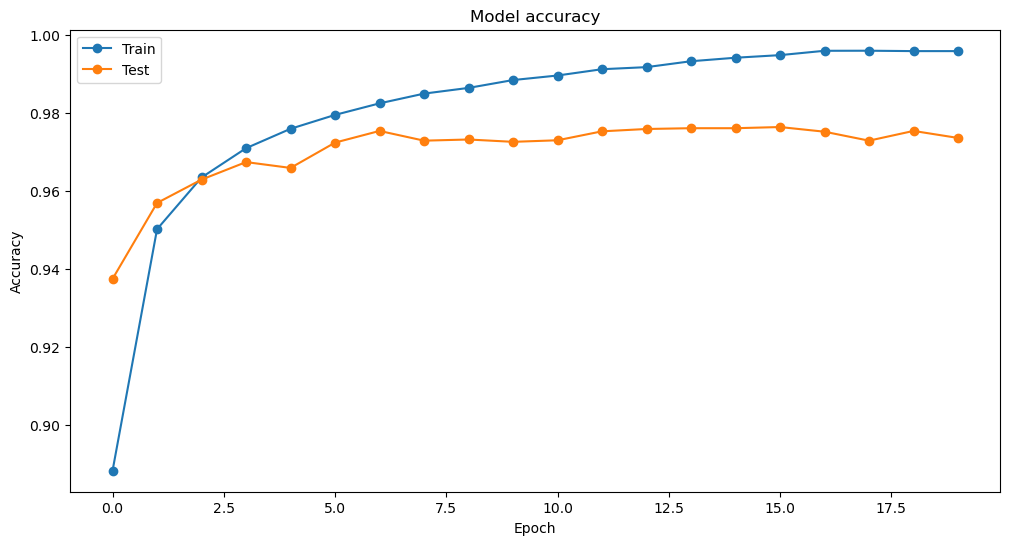

In [22]:
plot_accuracy(hist_dnn1);

The goal of deep learning models is to generalize well with the help of training data to any data from the problem domain. This is very crucial since we want our model to make predictions on the unseen dataset i.e, it has never seen before.

A similar picture we get from the loss function. Notice that we plot the figure below using a semilog plot.
The value of the loss function is decreasing, with some degradations beyond epoch 15.

However, it is remarkable that even beyond epoch 4, the loss function is not improving with the test set. It is going up over time. Another sign of **overfitting**. 

In Overfitting, the model tries to learn too many details in the training data along with the noise from the training data. As a result, the model performance is very poor on unseen or test datasets. Therefore, the network fails to generalize the features or patterns present in the training dataset.

In [23]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.semilogy(history.history['loss'],'o-')
    plt.semilogy(history.history['val_loss'],'o-')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left');

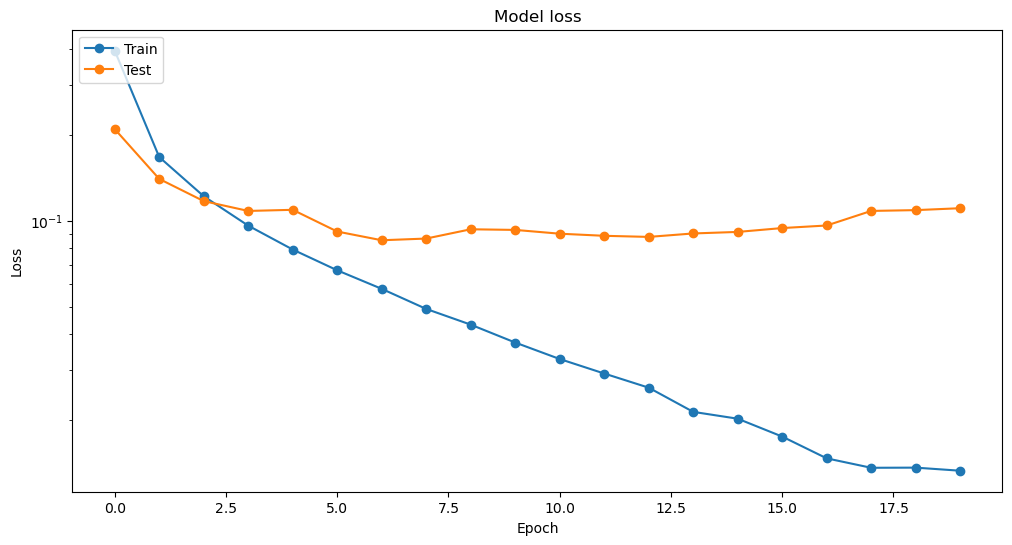

In [24]:
plot_loss(hist_dnn1);

Let's see if you can do better. Still, with the idea of a dense neural network, there are two things we can try.
Making the networks thicker or make them deeper. 

Let's see how far we can go with these options.

## Thicker Neural Network

In our first network, we use a couple of layers with $64$ neurons in them. What about doubling that figure to $128$?
We can think that with more neurons there are more parameters and those extra parameters will offer a richer landscape for optimizing better the weights.

As many things in Deep Learning and science in general, arguments, no matter how beautiful ones can be beaten by ugly facts. 

In [25]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(128, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
hist_dnn2 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.9115 - val_loss: 0.1465 - val_accuracy: 0.9565
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1227 - accuracy: 0.9639 - val_loss: 0.1174 - val_accuracy: 0.9639
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0848 - accuracy: 0.9743 - val_loss: 0.0872 - val_accuracy: 0.9729
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0627 - accuracy: 0.9805 - val_loss: 0.0834 - val_accuracy: 0.9741
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.0920 - val_accuracy: 0.9728
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0780 - val_accuracy: 0.9760
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0319 - accuracy: 0.9904 - val_loss: 0.0749 - val_accuracy: 0.9787
Epoch 

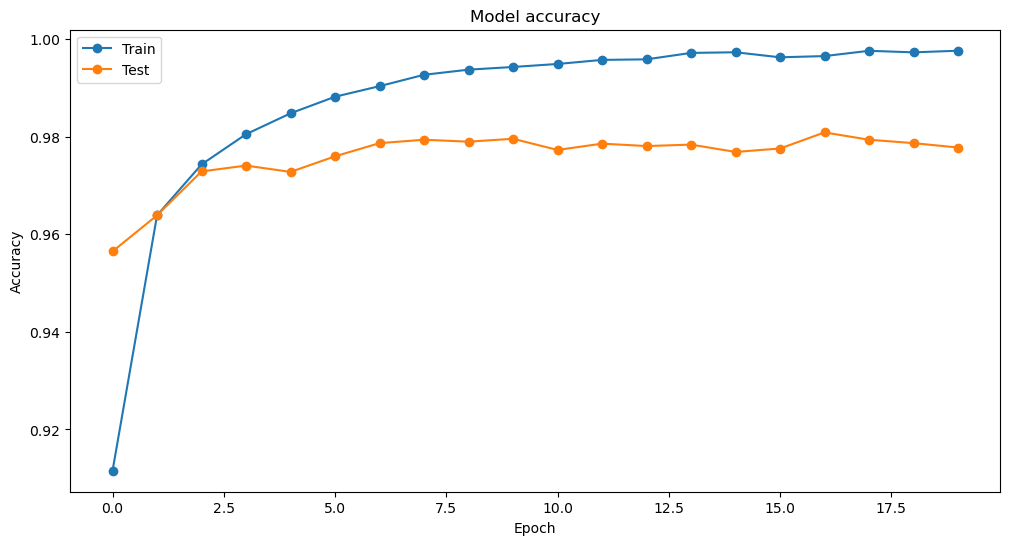

In [29]:
plot_accuracy(hist_dnn2);

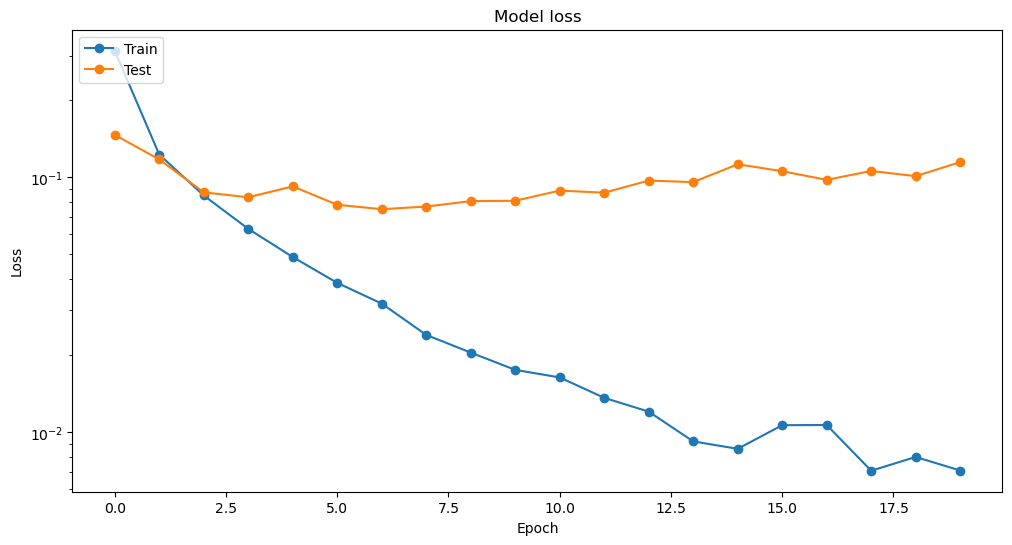

In [30]:
plot_loss(hist_dnn2);

The result is not indicative that **bigger** is **better**. 

We double the number of parameters, from 55 thousand to 118 thousand (See the summary of the model).

Neither the accuracy for the test set has been better or the loss function for the test set is lower. We are again stuck with unseen cases that are not well learning. 
Learning is not about memorizing what you see, learning is also about generalization, prospection, conexions.
That is true for our human meaning of "Learning" and the machine meaning for "learning".

What about deeper neural networks? 

## Deeper neural networks

Return to our original network, but this time instead we will add a couple of extra layers with $64$ neurons each.
Will this network start learning *deeper*?

In [31]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
Total params: 63,370
Trainable params: 63,370
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
hist_dnn3 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 1s 1ms/step - loss: 0.3885 - accuracy: 0.8833 - val_loss: 0.1880 - val_accuracy: 0.9437
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1565 - accuracy: 0.9535 - val_loss: 0.1411 - val_accuracy: 0.9581
Epoch 3/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1180 - accuracy: 0.9638 - val_loss: 0.1155 - val_accuracy: 0.9644
Epoch 4/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0942 - accuracy: 0.9721 - val_loss: 0.1092 - val_accuracy: 0.9656
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0783 - accuracy: 0.9761 - val_loss: 0.1168 - val_accuracy: 0.9650
Epoch 6/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0669 - accuracy: 0.9793 - val_loss: 0.0966 - val_accuracy: 0.9691
Epoch 7/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0573 - accuracy: 0.9818 - val_loss: 0.0920 - val_accuracy: 0.9732
Epoch 

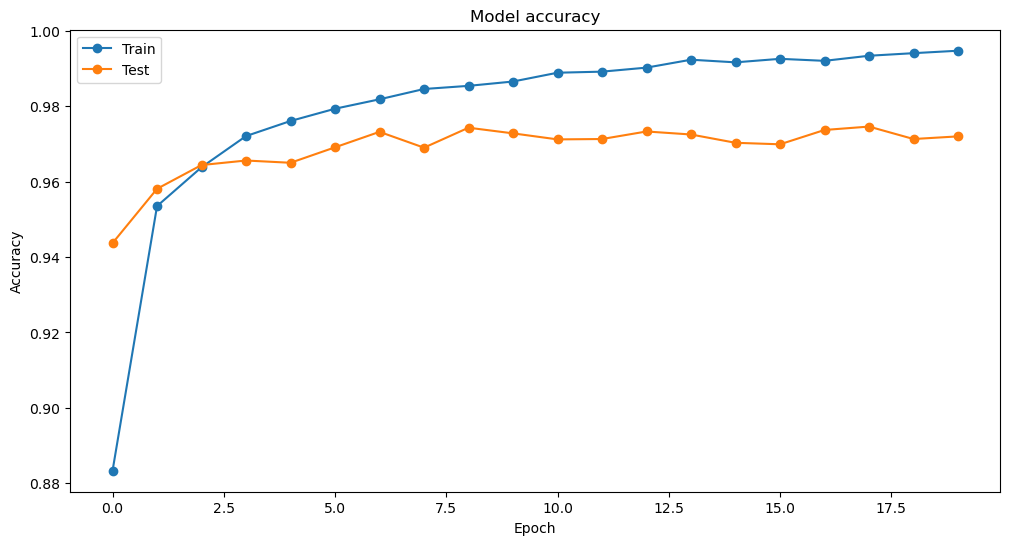

In [35]:
plot_accuracy(hist_dnn3);

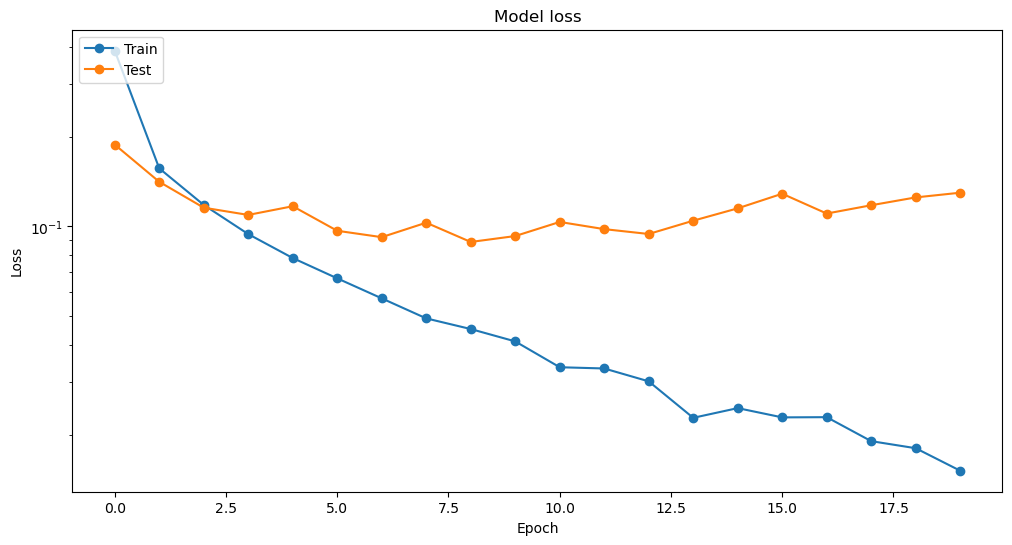

In [36]:
plot_loss(hist_dnn3);

Well, no *thicker* or *deeper* is helping us. With so many parameters, our network is remembering how to answer correctly for the training set but is not learning to generalize the parameters to also answer correctly for unseen images.

## Quick detour: Overfitting and the art of fitting elephants

John von Neumann famously said:

*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.*

This is quite appropriate to raise your attention to the risk of adding more parameters that do not improve anything.

Here is a realization of von Neumann's quote on a webpage from [John D Cook](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/). 

The original code was created by Piotr A. Zolnierczuk based on the paper:

    “Drawing an elephant with four complex parameters” 
    by Jurgen Mayer, Khaled Khairy, and Jonathon Howard,  
    Am. J. Phys. 78, 648 (2010), DOI:10.1119/1.3254017.

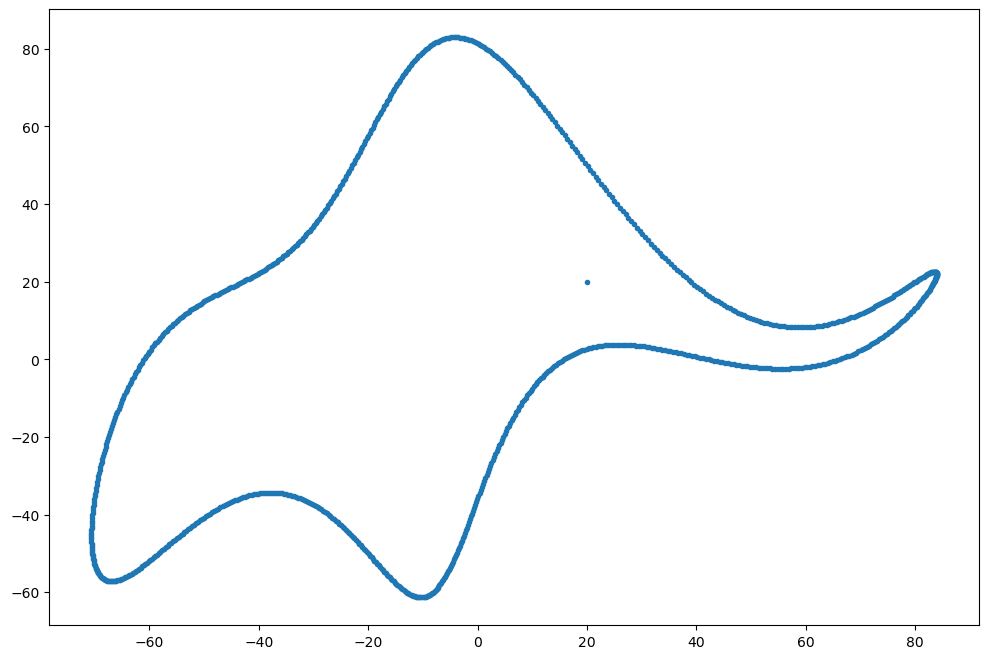

In [37]:
"""
Author: Piotr A. Zolnierczuk (zolnierczukp at ornl dot gov)

Based on a paper by:
Drawing an elephant with four complex parameters
Jurgen Mayer, Khaled Khairy, and Jonathon Howard,
Am. J. Phys. 78, 648 (2010), DOI:10.1119/1.3254017
"""
import numpy as np
import pylab

# elephant parameters
p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    x = np.append(fourier(t,Cx), [-p5.imag])
    y = np.append(fourier(t,Cy), [p5.imag])

    return x,y

plt.figure(figsize=(12, 8))
x, y = elephant(np.linspace(0,2*np.pi,1000), p1, p2, p3, p4, p5)
pylab.plot(y,-x,'.')
pylab.show()

## No thicker, no deeper, what is next?

Lets summarize the results from our 3 networks:

| Network Architecture | Number of trainable parameters | Test Lost | Test Accuracy | Validation Loss | Validation Accuracy |
|---|---|---|---|---|---|
| 64 $\times$ 64 $\times$ 10 | 55,050 | 0.0033 | 0.9991 | 0.1379 | 0.9762 |
| 128 $\times$ 128 $\times$ 10 | 118,282 | 0.0064 | 0.9979 | 0.1261 | 0.9782 | 
| 64 $\times$ 64 $\times$ 64 $\times$ 64 $\times$ 10 | 63,370 | 0.0096 | 0.9971 | 0.1556 | 0.9749 |

So adding more neurons on a layer or adding more layers is not helping. Where is the problem?

For physicists, there is a guiding principle in many areas:

      Follow the symmetries!

Imagine one of the images in our training set. What if we take the image and we shift the image one pixel.
From our eyes (and brain). The image is the same. Translation symmetry is trivial for an image but from the point of view of our neural networks, the original image and the translated image look very different. 
Many input cells are changed and this is an unfortunate effect of flattening our 2D array into a 1D array. 

In addition to the flattening, the neural network is not using the grid arrangement of the pixels and the corresponding arrays.

These limitations have been addressed by the so-called **Convolutional Neural Networks** (CNN). CNN's are the correct way of doing image recognition with neural networks.

# Convolutional Neural Networks

**A convolutional neural network (CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other**. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets can learn these filters/characteristics.

## AlexNet

AlexNet won the ImageNet Large Scale Visual Recognition Competition (ILSVRC) and revolutionized Deep Learning.

![AlexNet1](./fig/AlexNet1.png)

![AlexNet2](./fig/AlexNet2.png)


## A convolution

<!--
![Convolution](./fig/convolution.svg)

![Convolution 11](./fig/convolution11.svg)

![Convolution 23](./fig/convolution23.svg)
-->

<img src="./fig/convolution.svg" width=500 height=500 />
<img src="./fig/convolution11.svg" width=500 height=500 />
<img src="./fig/convolution23.svg" width=500 height=500 />

![CNN](./fig/cnn.jpeg)



As seen from this figure, CNN consists of several convolutional and subsampling layers optionally followed by fully connected layers. 

Let us say that our input to the convolutional layer is a $m \times m \times r$ pixels in an image where $m$ is the height and width of the image and $r$ is the number of channels, e.g. an RGB image has $r=3$. The convolutional layer will have $k$ filters (or kernels) of size $n \times n \times q$ where n is smaller than the dimension of the image and $q$ can either be the same as the number of channels r or smaller and may vary for each kernel. The size of the filters gives rise to the locally connected structure which is each convolved with the image to produce k feature maps of size $m−n+1$. 


A simple demonstration is shown in the figure below, where we assume a binary picture and a single filter of a 3x3 matrix. The primary purpose of Convolution is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data. The orange square slide over the figure and for each 3x3 overlap, I multiply every element of the 3x3 submatrix of the figure with the convolution and then I add all elements afterward. 

![ConvNet](./fig/ConvNet.jpeg)
 
 Let see how this works

![CNN](./fig/MovieCN.gif)


 It is clear that different values of the filter matrix will produce different Feature Maps for the same input image.
 
 Typical filter matrices are now described. 
 
 For edge detection:
 $
\begin{bmatrix}
1&0&-1\\
0&0&0\\
-1&0&1\\
\end{bmatrix}
\;\;
\begin{bmatrix}
0&1&0\\
1&-4&1\\
0&1&0\\
\end{bmatrix}
\;\;
\begin{bmatrix}
-1&-1&-1\\
-1&8&-1\\
-1&-1&-1\\
\end{bmatrix}
$

For sharpen:
$
\begin{bmatrix}
0&-1&0\\
-1&5&-1\\
0&-1&0\\
\end{bmatrix}
$

In practice, a CNN learns the values of these filters on its own during the training process (although we still need to specify parameters such as the number of filters, filter size, architecture of the network, etc. before the training process). The more filters we have, the more image features get extracted, and the better our network becomes at recognizing patterns in unseen images.

The other step that is described in this section is the pooling. Spatial Pooling (also called subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum, etc.

## MNIST classification using a simple CNN

In [ ]:
#mnist = tf.keras.datasets.mnist
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images = train_images.reshape(60000, 28, 28, 1) 
test_images = test_images.reshape(10000, 28, 28, 1) 
train_images, test_images = train_images/255, test_images/255

In [ ]:
tf.keras.layers.MaxPooling2D(2,2),

In [ ]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [ ]:
hist_cnn1 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

In [ ]:
plot_accuracy(hist_cnn1);

In [ ]:
plot_loss(hist_cnn1);

## Adding another convolutional layer

In [ ]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [ ]:
hist_cnn2 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

In [ ]:
plot_accuracy(hist_cnn2);

In [ ]:
plot_loss(hist_cnn2);

## Adding dropout

It looks counterintuitive but sometimes it is good to prune networks. The technique is called dropout and it is used to reduce overfitting.  

When using the Dropout layer, it randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent **overfitting**. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies during **training**, ie no neurons are dropped during inference. When using `model.fit`, training will be appropriately set to True automatically.

In [ ]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [ ]:
hist_cnn3 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

In [ ]:
plot_accuracy(hist_cnn3);

In [ ]:
plot_loss(hist_cnn3);

## Summarizing all neural networks we used

In [ ]:
plt.figure(figsize=(12, 6))

for ihist in [hist_dnn1, hist_dnn2, hist_dnn3, hist_cnn1, hist_cnn2, hist_cnn3]:
    plt.plot(ihist.history['val_accuracy'],'o-')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([r'DNN $64 \times 64 \times 10$', 
            r'DNN $128 \times 128 \times 10$', 
            r'DNN $64 \times 64 \times 64 \times 64 \times 10$', 
            r'CNN $c32mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times dp.25 \times d100 \times d10$'], loc='lower right');

In [ ]:
plt.figure(figsize=(12, 6))

for ihist in [hist_dnn1, hist_dnn2, hist_dnn3, hist_cnn1, hist_cnn2, hist_cnn3]:
    plt.plot(ihist.history['val_loss'],'o-')

plt.title('Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([r'DNN $64 \times 64 \times 10$', 
            r'DNN $128 \times 128 \times 10$', 
            r'DNN $64 \times 64 \times 64 \times 64 \times 10$', 
            r'CNN $c32mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times dp.25 \times d100 \times d10$'], loc='lower right');

# Building Deep Learning models using low-level TensorFlow 1.x

As we saw above, Keras offers an easy and high-level API for building both dense and convolutional Neural Networks with just a few lines of code.

At this point is also illustrative how the model can be built explicitly on TensorFlow using the old TensorFlow 1.x API.

We start with a set of functions and classes for processing the original MNIST dataset. 

In [ ]:
"""Functions for downloading and reading MNIST data."""

import gzip
import os
import shutil
import urllib.request
import numpy
import tempfile
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'

def maybe_download(filename, work_directory, data_directory):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    filepath = os.path.join(data_directory, filename)
    filepath2 = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    shutil.copyfile(filepath, filepath2)
    return filepath2

def _read32(bytestream):
    dt = numpy.dtype(numpy.uint32).newbyteorder('>')
    return numpy.frombuffer(bytestream.read(4), dtype=dt)


def extract_images(filename):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)[0]
        rows = _read32(bytestream)[0]
        cols = _read32(bytestream)[0]
        print(f"Detected {num_images} images of size {rows} x {cols}")
        buf = bytestream.read(rows * cols * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def extract_labels(filename, one_hot=False):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
                'Invalid magic number %d in MNIST label file: %s' %
                (magic, filename))
        num_items = _read32(bytestream)[0]
        buf = bytestream.read(num_items)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
        if one_hot:
            return dense_to_one_hot(labels)
        return labels


class DataSet(object):
    def __init__(self, images, labels, fake_data=False):
        if fake_data:
            self._num_examples = 10000
        else:
            assert images.shape[0] == labels.shape[0], (
                "images.shape: %s labels.shape: %s" % (images.shape,
                                                       labels.shape))
            self._num_examples = images.shape[0]
            # Convert shape from [num examples, rows, columns, depth]
            # to [num examples, rows*columns] (assuming depth == 1)
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                                    images.shape[1] * images.shape[2])
            # Convert from [0, 255] -> [0.0, 1.0].
            images = images.astype(numpy.float32)
            images = numpy.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False):
        """Return the next `batch_size` examples from this data set."""
        if fake_data:
            fake_image = [1.0 for _ in xrange(784)]
            fake_label = 0
            return [fake_image for _ in xrange(batch_size)], [
                fake_label for _ in xrange(batch_size)]
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = numpy.arange(self._num_examples)
            numpy.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, data_dir, fake_data=False, one_hot=False):
    class DataSets(object):
        pass
    data_sets = DataSets()
    if fake_data:
        data_sets.train = DataSet([], [], fake_data=True)
        data_sets.validation = DataSet([], [], fake_data=True)
        data_sets.test = DataSet([], [], fake_data=True)
        return data_sets
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
    VALIDATION_SIZE = 5000
    local_file = maybe_download(TRAIN_IMAGES, train_dir, data_dir)
    train_images = extract_images(local_file)
    local_file = maybe_download(TRAIN_LABELS, train_dir, data_dir)
    train_labels = extract_labels(local_file, one_hot=one_hot)
    local_file = maybe_download(TEST_IMAGES, train_dir, data_dir)
    test_images = extract_images(local_file)
    local_file = maybe_download(TEST_LABELS, train_dir, data_dir)
    test_labels = extract_labels(local_file, one_hot=one_hot)
    validation_images = train_images[:VALIDATION_SIZE]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_images = train_images[VALIDATION_SIZE:]
    train_labels = train_labels[VALIDATION_SIZE:]
    data_sets.train = DataSet(train_images, train_labels)
    data_sets.validation = DataSet(validation_images, validation_labels)
    data_sets.test = DataSet(test_images, test_labels)
    return data_sets

In [ ]:
tempdir = tempfile.mkdtemp()
print(tempdir)

# Cleaning

In [ ]:
shutil.rmtree(tempdir)

# Exercises

  1. MNIST is a relatively simple dataset. Try to get the simplest network that gives you a 95% accuracy with the validation data. 
     Check the number of trainable parameters as your measure of simplicity. Imagine that it will be deployed on very modest hardware and you cannot have the luxury of storing hundreds of thousands of parameters.

  1. What happens to the number of parameters if we remove the MaxPooling2D from the network architecture?
     Use model.summary() to check for that. Do not try to train such a network.
   

## From A to Z with a single data set

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

In [40]:
dataFolder = 'data/'
dataFile = dataFolder + "iris.csv"
print(dataFile)

data/iris.csv


In [41]:
df = pd.read_csv(dataFile)
df.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [42]:
# Split into X and Y

X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
print(X[0:5])
print(y[0:5])

[[4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


In [43]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)

In [45]:
# Convert Y into one hot encoding

Y = pd.get_dummies(y1).values
print(Y[0:5])

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [47]:
# convert X and Y into train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print(X_train[0:5])
print(X_train.shape)

[[5.2 3.4 1.4 0.2]
 [5.1 2.5 3.  1.1]
 [6.2 2.9 4.3 1.3]
 [5.9 3.2 4.8 1.8]
 [5.1 3.8 1.5 0.3]]
(119, 4)


In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
model

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, epochs=100, validation_data=(X_test,y_test))

Epoch 1/100
3/3 [==============================] - 0s 32ms/step - loss: 4.1163 - accuracy: 0.3361 - val_loss: 3.5789 - val_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 3.6278 - accuracy: 0.3361 - val_loss: 3.2838 - val_accuracy: 0.3333
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 3.3066 - accuracy: 0.3361 - val_loss: 3.0085 - val_accuracy: 0.3333
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 3.0168 - accuracy: 0.3361 - val_loss: 2.7885 - val_accuracy: 0.3333
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 2.7831 - accuracy: 0.3361 - val_loss: 2.5999 - val_accuracy: 0.3333
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 2.5777 - accuracy: 0.3361 - val_loss: 2.4223 - val_accuracy: 0.3333
Epoch 7/100
3/3 [==============================] - 0s 7ms/step - loss: 2.3837 - accuracy: 0.3361 - val_loss: 2.2556 - val_accuracy: 0.3333
Epoch 8/100
3/3 [=========

3/3 [==============================] - 0s 8ms/step - loss: 0.6504 - accuracy: 0.7311 - val_loss: 0.6372 - val_accuracy: 0.9667
Epoch 60/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6435 - accuracy: 0.7479 - val_loss: 0.6304 - val_accuracy: 0.9000
Epoch 61/100
3/3 [==============================] - 0s 8ms/step - loss: 0.6371 - accuracy: 0.8992 - val_loss: 0.6282 - val_accuracy: 0.7667
Epoch 62/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6300 - accuracy: 0.7059 - val_loss: 0.6203 - val_accuracy: 0.9667
Epoch 63/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.8319 - val_loss: 0.6163 - val_accuracy: 0.7667
Epoch 64/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.7311 - val_loss: 0.6109 - val_accuracy: 0.7667
Epoch 65/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6166 - accuracy: 0.7395 - val_loss: 0.6056 - val_accuracy: 0.9333
Epoch 66/100
3/3 [==============

In [49]:
# Ev aluate the model

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.332052618265152
Test accuracy: 1.0


In [50]:
print(X_test.shape)
y_pred = model.predict(X_test)
y_pred

(30, 4)
1/1 [==============================] - 0s 53ms/step


array([[0.01724258, 0.2754913 , 0.70726615],
       [0.03097438, 0.44527024, 0.52375543],
       [0.08230872, 0.55884653, 0.35884485],
       [0.10312575, 0.6238503 , 0.27302393],
       [0.8729721 , 0.10795872, 0.01906925],
       [0.00847399, 0.19220547, 0.7993206 ],
       [0.02755072, 0.41091546, 0.5615338 ],
       [0.0671365 , 0.61925375, 0.31360972],
       [0.02357943, 0.29223704, 0.6841835 ],
       [0.06100899, 0.6307412 , 0.3082499 ],
       [0.90869886, 0.07958527, 0.01171589],
       [0.8926201 , 0.09284845, 0.01453151],
       [0.05100723, 0.5363485 , 0.4126443 ],
       [0.8831983 , 0.10112239, 0.01567928],
       [0.89630586, 0.08888046, 0.01481369],
       [0.03025405, 0.42407703, 0.54566896],
       [0.01837316, 0.32054493, 0.66108185],
       [0.07818151, 0.6506371 , 0.2711814 ],
       [0.9354955 , 0.05706168, 0.00744281],
       [0.9381048 , 0.05471951, 0.00717578],
       [0.8240704 , 0.14828973, 0.02763994],
       [0.90869886, 0.07958527, 0.01171589],
       [0.

---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfellow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

In [ ]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [ ]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')